In [130]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import random

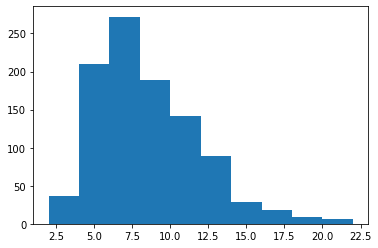

In [131]:
def inters_rv():
    return round(scipy.stats.gamma.rvs(a=3, loc=0, scale=2) + 2.0)

s = []
for i in range(0,1000):
    s.append(inters_rv())

plt.hist(s)
plt.show()

In [191]:
verbose = False

N = [0,1]
NE = [1,1]
E = [1,0]
SE = [1,-1]
S = [0,-1]
SW = [-1,-1]
W = [-1,0]
NW = [-1,-1]

class Node:
    def __init__(self, x, y, is_inters=False, is_plaza=False, orig_dist=0, inters_dist=0, neigh=[], parent=None):
        self.x = x
        self.y = y
        self.is_inters = is_inters
        self.orig_dist = orig_dist
        self.inters_dist = inters_dist
        self.neigh = neigh
        self.parent = parent
        self.is_plaza = False

    def get_eligible(self):
        parent_relative = None
        if self.parent!=None:
            parent_relative = [self.parent.x - self.x, self.parent.y - self.y]

        if self.is_inters:
            eligible = [N, E, S, W]
        else:
            # Only straight - calculate node opposite parent
            eligible = [[parent_relative[0] * -1, parent_relative[1] * -1]]

        for n in self.neigh:
            neigh = [n.x - self.x, n.y - self.y]
            if neigh in eligible:
                eligible.remove(neigh)
        if parent_relative in eligible:
            eligible.remove(parent_relative)
        
        return eligible

    def coord_str(self):
        return('(%d,%d)' % (self.x, self.y))

    def __str__(self):
        return '(%d,%d,n=%d,od=%d,id=%d) <= %s' % (self.x, self.y, len(self.neigh), self.orig_dist, self.inters_dist, self.parent)

def draw_map(existing, origin=None, new=None):
    for y in range(-20,21):
        for x in range(-20,21):
            if origin!=None and origin.x==x and origin.y==y:
                    print('o', end='')
            elif new!=None and new.x==x and new.y==y:
                    print('+', end='')
            elif '(%d,%d)' % (x,y) in existing:
                n = existing['(%d,%d)' % (x,y)]
                if n.is_inters:
                    print('x', end='')
                else:
                    print('▪', end='')
            else:
                print(' ', end='')
        print('')

def generate(existing, origins, wiggle=3, steps=500):
    for i in range(0,steps):
        if verbose:
            print("\nIteration %d" % i)
        min_od = None
        od = 0

        candidates = []
        search = origins
        while min_od==None or od<min_od+wiggle-1:
            adj = []
            od += 1
            for n in search:
                if verbose:
                    print('Visiting %s' % n)
                for a in n.neigh:
                    if verbose:
                        print('New search: %s' % a)
                    adj.append(a)
                    existing[a.coord_str()] = a

                eligible = n.get_eligible()
                for c in eligible:
                    if '(%d,%d)' % (n.x+c[0], n.y+c[1]) in existing:
                        continue

                    if min_od==None:
                        min_od = n.orig_dist+1

                    cand = Node(
                        n.x+c[0],
                        n.y+c[1],
                        orig_dist=n.orig_dist+1,
                        inters_dist=n.inters_dist+1,
                        parent=n,
                        neigh=[],
                    )

                    if verbose:
                        print('Found canditate: %s' % cand)
                    candidates.append(cand)
                
            search = adj

        if len(candidates)==0:
            if verbose:
                print('No candidates found')
            break 

        new = np.random.choice(candidates)
        if new.inters_dist>=inters_rv():
            # Intersection
            if random.randint(0,100)<1:
                # Plaza - this triggers intersections on the next tile
                new.inters_dist = 100
            else:
                new.inters_dist = 0
            new.is_inters = True
        else:
            if random.randint(0,100)<2:
                # Long road from here
                new.inters_dist = -10

        if verbose:
            print('Adding node: %s' % new)
        new.parent.neigh.append(new)
        existing[new.coord_str()] = new

origins = [
    Node(0,0,is_inters=True,inters_dist=100),
]
existing = {}
for o in origins:
    existing[o.coord_str()] = o

generate(existing, origins, wiggle=3, steps=500)
draw_map(existing)

               ▪    ▪                    
               x▪▪▪▪x▪▪▪▪x               
               ▪    ▪                    
             x▪▪    ▪                    
             ▪      ▪                    
             ▪      ▪                    
         x   ▪      ▪                    
         ▪   ▪      ▪                    
         ▪   ▪      ▪                    
         ▪▪▪▪x▪▪▪▪▪▪x▪▪▪▪▪▪▪▪▪▪▪▪▪▪      
         ▪   ▪ ▪    ▪         ▪          
   ▪     ▪   ▪ ▪    ▪         ▪     ▪    
   ▪     ▪   ▪ ▪    ▪         ▪     ▪    
   ▪     ▪   ▪ ▪    ▪         ▪     ▪    
  ▪x▪▪▪▪▪x▪▪▪▪▪x▪▪▪▪x▪▪▪▪▪▪▪▪▪▪     ▪    
 ▪▪x▪▪▪▪▪x▪▪▪▪▪▪x▪▪▪▪▪▪x▪▪▪▪▪▪x▪▪▪▪▪x▪▪▪▪
   ▪ ▪   ▪▪     ▪  ▪▪  ▪    ▪ ▪    ▪▪    
   ▪ ▪   ▪▪     ▪  ▪▪  ▪    ▪ ▪    ▪x▪   
   ▪ ▪   ▪▪     ▪  ▪▪  ▪    ▪ ▪    ▪▪    
     ▪   ▪▪     ▪  ▪x▪▪x▪▪▪▪x▪▪▪▪▪▪▪▪    
▪▪▪▪▪x▪▪▪▪x▪▪▪▪▪x▪▪xxx▪▪▪▪▪x▪▪▪▪▪▪▪x▪▪▪▪▪
     ▪    ▪     ▪  ▪x▪▪▪▪▪▪▪       ▪     
 ▪   ▪    ▪     ▪  ▪▪    ▪ ▪       ▪     
 ▪   ▪    ▪     ▪  ▪▪    ▪ ▪      